# Yelp Data Challenge - Data Preprocessing

Filter down data to save space and facilitate further goals: sentiment analysis, clustering of textual reviews, and building a recommendation system.

## Dataset Introduction

[Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge)

The Challenge Dataset:

    4.1M reviews and 947K tips by 1M users for 144K businesses
    1.1M business attributes, e.g., hours, parking availability, ambience.
    Aggregated check-ins over time for each of the 125K businesses
    200,000 pictures from the included businesses

Cities:

    1111 unique cities from all across the globe. This project will work with Las Vegas,
    which is a popular destination with ample data entries.

Files:

    yelp_academic_dataset_business.json
    yelp_academic_dataset_checkin.json
    yelp_academic_dataset_review.json
    yelp_academic_dataset_tip.json
    yelp_academic_dataset_user.json

Notes on the Dataset

    Each file is composed of a single object type, one json-object per-line.
    Examples to get started: https://github.com/Yelp/dataset-examples.



## Read data into pandas.DataFrame; basic preprocessing

In [1]:
import json
from typing import *
import pandas as pd
import numpy as np

In [2]:
file_business, file_checkin, file_review, file_tip, file_user = [
    'yelp_dataset/yelp_academic_dataset_business.json',
    'yelp_dataset/yelp_academic_dataset_checkin.json',
    'yelp_dataset/yelp_academic_dataset_review.json',
    'yelp_dataset/yelp_academic_dataset_tip.json',
    'yelp_dataset/yelp_academic_dataset_user.json'
]

### Business Data

In [3]:
with open(file_business) as f:
    df_business = pd.DataFrame(json.loads(line) for line in f)

df_business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,,1314 44 Avenue NE,Calgary,AB,T2E 6L6,51.091813,-114.031675,4.0,24,1,"{'BikeParking': 'False', 'BusinessAcceptsCredi...","Tours, Breweries, Pizza, Restaurants, Food, Ho...","{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'..."
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,,,Henderson,NV,89002,35.960734,-114.939821,4.5,3,0,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...","Chicken Wings, Burgers, Caterers, Street Vendo...","{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0..."


In [4]:
# There are various names that refer to Las Vegas, with mixes of cases and spaces

for city in df_business.city.unique():
    if city.lower().startswith("las"):
        print(city)

print(f"{(df_business.city == 'Las Vegas').sum()} entries already named 'Las Vegas'")

Las Vegas
las vegas
Lasalle
LaSalle
las Vegas
Las  Vegas
Las vegas
Las Vegass
LasVegas
Las Vegas East
Las Vegas,
Las Vegas Nv
Las Vegas & Henderson
Las Vegas, NV
Las Vegas Nevada
28865 entries already named 'Las Vegas'


In [5]:
# Let's standardize all relevant names to "Las Vegas"
# Ignoring Las Vegas East and Las Vegas & Henderson, which are nowhere near touristy areas

valid_city_names = set(["las vegas", "las Vegas", "Las  Vegas", "Las vegas", "LasVegas",
                        "Las Vegass", "Las Vegas,", "Las Vegas Nv", "Las Vegas, NV", 
                        "Las Vegas Nevada"])

def fix_city_name(old_name: str, names_to_replace: Iterable[str], 
                  new_name: str = None) -> str:
    return new_name if old_name.strip() in names_to_replace else old_name

In [6]:
# Verify that there are ample entries on Las Vegas
# So we have fixed around a few dozens of entries...alright.

df_business.city = df_business.city.apply(fix_city_name, 
                                          args=(valid_city_names, "Las Vegas"))

# Print new set of unique values to verify
for city in df_business.city.unique():
    if city.lower().startswith("las"):
        print(city)

print(f"{(df_business.city == 'Las Vegas').sum()} entries now named 'Las Vegas'")

Las Vegas
Lasalle
LaSalle
Las Vegas East
Las Vegas & Henderson
28922 entries now named 'Las Vegas'


In [7]:
# Missing values in categories, will impute very soon
df_business.isna().sum()

business_id         0
name                0
neighborhood        0
address             0
city                0
state               0
postal_code         0
latitude            6
longitude           6
stars               0
review_count        0
is_open             0
attributes      25786
categories        541
hours           44802
dtype: int64

### Review Data
30 secs loading time on a MBP with 16GB of RAM. 

In [8]:
with open(file_review) as f:
    df_review = pd.DataFrame(json.loads(line) for line in f)
df_review.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,x7mDIiDB3jEiPGPHOmDzyw,msQe1u7Z_XuqjGoqhB0J5g,iCQpiavjjPzJ5_3gPD5Ebg,2,2011-02-25,The pizza was okay. Not the best I've had. I p...,0,0,0
1,dDl8zu1vWPdKGihJrwQbpw,msQe1u7Z_XuqjGoqhB0J5g,pomGBqfbxcqPv14c3XH-ZQ,5,2012-11-13,I love this place! My fiance And I go here atl...,0,0,0


## Filter `df_business` by `city` and `category`
Extract all entries from `df_business` pertaining to "Restaurants" in "Las Vegas". 

In [11]:
df_business = df_business.query("`city` == 'Las Vegas'")

# Impute missing categories as 'Unknown'
df_business["categories"].replace(np.nan, "Unknown", inplace=True)

# Selection below only works AFTER imputation,
df_business = df_business.loc[df_business.categories.str.match("Restaurants")]

### Keep only relevant columns in `df_business` 
Which features are useful for building a recommendation system?

    - business_id --- for computers to uniquely identifying each restaurant (branch)
    - name --- for us humans to identify restaurant 
    - categories --- more human-readable information for understanding the restaurant
    - stars --- the average star rating given to each restaurant
    - attributes --- more text attributes describing each restaurant in detail

In [12]:
df_business.columns  # existing columns

Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [13]:
selected_features = [u'business_id', u'name', u'categories', u'stars', u'attributes']
df_business = df_business.loc[:, selected_features]

# Rename column "stars" to "avg_stars" to avoid conflict with review dataset
# 'avg_stars' is the rating a restaurant received, averaged over all reviews
df_business.rename(axis="columns", mapper={"stars": "avg_stars"}, inplace=True)

In [14]:
# Inspect DataFrame
df_business.head()

,business_id,name,categories,avg_stars,attributes
143,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': '{'romantic': ..."
197,YV9GVfmDSDM7HSV0jVdTOA,El Pollo Loco,"Restaurants, Salad, Fast Food, Mexican",3.0,"{'Alcohol': 'none', 'Ambience': '{'romantic': ..."
325,lv5Bnqlt93NnvNJ2oNcQ8Q,Los Cucos Mexican Cafe,"Restaurants, Bars, Nightlife, Caterers, Mexica...",4.0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti..."
630,DbK9fyJq4O4zfT1jv6JOhw,Pam Real Thai Las Vegas,"Restaurants, Food, Food Delivery Services, Thai",4.0,"{'Alcohol': 'none', 'Ambience': '{'romantic': ..."
1061,Kx0MUrNQ737s-VVElk6Vig,Las Delicias De Las Vegas,"Restaurants, Mexican",4.0,"{'Alcohol': 'none', 'Ambience': '{'romantic': ..."


### Save filtered `df_business` DataFrame
Caching intermediate result

In [15]:
df_business.to_csv("data/selected_business.csv", index=False)

## Filter `df_review` by `business_id` and `date`
Extract only "recent" reviews about Las Vegan restaurants.

In [16]:
df_left = df_business.set_index("business_id")
df_right = df_review.set_index("business_id")
df_br_joined = df_left.join(df_right, how="inner").reset_index() 

print(df_br_joined.isna().sum())
del df_left, df_right

business_id      0
name             0
categories       0
avg_stars        0
attributes     475
review_id        0
user_id          0
stars            0
date             0
text             0
useful           0
funny            0
cool             0
dtype: int64


In [17]:
# What is the latest review in the data?
df_br_joined.date.max()

'2018-07-02'

In [19]:
# Filter down to the latest two+ years
df_br_joined = df_br_joined.query("`date` > '2016-01-01'")

## Save joined businesses + reviews dataset to CSV file

In [21]:
# Save to ./data/last_2_years_restaurant_reviews.csv for your next task
df_br_joined.to_csv("data/last_2_years_restaurant_reviews.csv", index=False)

## Basic EDA on processed data
Each row of `df_br_joined` contains a review, and data about the restaurant reviewed. We can explore the data, and obtain insights for our recommendation system, or simply interesting behaviorial patterns among users.

In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Text(0, 0.5, "Number of 'useful' votes")

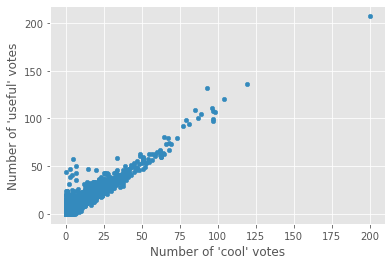

In [26]:
# Obvious, almost-linear correlation between the numbers of "useful" and "cool" tags per review
# Front-end product question: is one of the tags redundant?
# In any case, can pick EITHER ONE to weigh the importance of each review when building recommendation system!

df_br_joined.plot.scatter(x="cool", y="useful")
plt.xlabel("Number of 'cool' votes")
plt.ylabel("Number of 'useful' votes")

          useful     stars
useful  1.000000 -0.034555
stars  -0.034555  1.000000


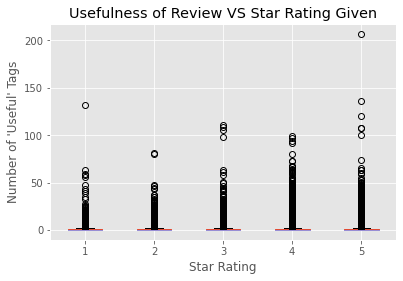

In [28]:
# Weak between usefulness of reviews and star rating given to restaurant
df_br_joined.boxplot(by="stars", column="useful")
plt.title("Usefulness of Review VS Star Rating Given")
plt.suptitle("")
plt.xlabel("Star Rating")
plt.ylabel("Number of 'Useful' Tags") 

# Confirm weak correlation
print(df_br_joined.loc[:, ["useful", "stars"]].corr())

<AxesSubplot:title={'center':'Number of Reviews, At Each Average Rating'}, xlabel='Average Rating', ylabel='Number of Reviews'>

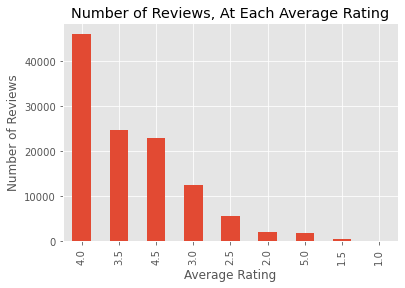

In [30]:
# Are the reviews concentrated in certain (average) ratings? Yes!
# Possible implication: people don't bother to leave reviews for really bad restaurants
# Not sure why so few reviews give 5.0 though; maybe perfect restaurants are hard to find ;)

reviews_per_star = df_br_joined['avg_stars'].value_counts()\
                                            .sort_index()

plt.title("Number of Reviews, At Each Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
reviews_per_star.plot.bar()